In [ ]:
import pickle
import pandas as pd
# Load the dataset
file_path = "/content/smart_app_data.pkl"
historical_data = pd.read_pickle(file_path)

In [ ]:
print(historical_data['kpi'].unique())

['working_time' 'idle_time' 'offline_time' 'consumption' 'power'
 'consumption_working' 'consumption_idle' 'cost' 'cost_working'
 'cost_idle' 'cycles' 'good_cycles' 'bad_cycles' 'average_cycle_time']


In [ ]:
print(historical_data['name'].unique())

['Large Capacity Cutting Machine 1' 'Riveting Machine'
 'Medium Capacity Cutting Machine 1' 'Laser Cutter'
 'Large Capacity Cutting Machine 2' 'Medium Capacity Cutting Machine 2'
 'Testing Machine 1' 'Testing Machine 2' 'Low Capacity Cutting Machine 1'
 'Medium Capacity Cutting Machine 3' 'Assembly Machine 1'
 'Laser Welding Machine 1' 'Assembly Machine 2' 'Assembly Machine 3'
 'Laser Welding Machine 2' 'Testing Machine 3']


In [ ]:
def extract_features(kpi_name, kpi_value, machine_name, data):

  # function that is able to extract time series filtering for:
  # kpi_vame = name of the kpi
  # kpi_value = which should be chose in the list ['avg', 'sum', 'min', 'max']
  # machine_name = name of the machine
  # data = name of the dataframe from which data are provided

  filtered_data = data[(data["name"] == machine_name) &
                    (data["kpi"] == kpi_name)]
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])
  filtered_data = filtered_data.sort_values(by='time')

  extracted_features = filtered_data[["time", kpi_value]]

  return extracted_features

# USAGE
kpi = "working_time"
metric = "avg"
machine = "Assembly Machine 1"
feature_extracted = extract_features(kpi, metric, machine, historical_data)


<ipython-input-6-68039b06ca71>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


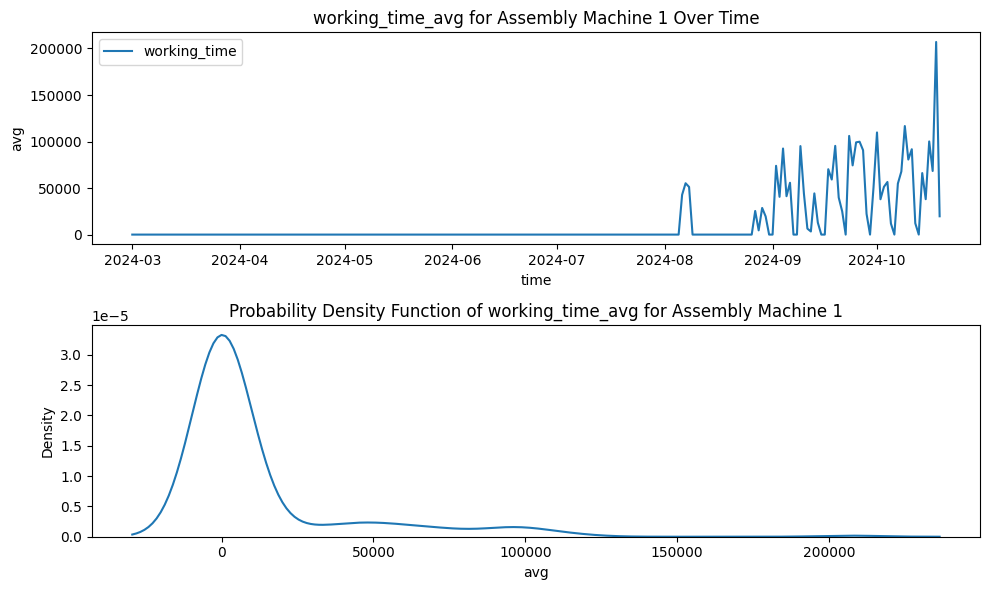

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_feature(features, machine_name, kpi_name, kpi_value):
    """
    Plots the values in the second column of 'features' DataFrame over the first column
    and its probability density function.

    Args:
        features (pd.DataFrame): The input data containing two columns to plot.
        machine_name (str): The name of the machine (for plot title).
        kpi_name (str): The name of the KPI (for plot title).
    """

    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))

    # Plot the second column over the first column
    axes[0].plot(features.iloc[:, 0], features.iloc[:, 1], label=f"{kpi_name}")
    axes[0].set_title(f"{kpi_name}_{kpi_value} for {machine_name} Over Time")
    axes[0].set_xlabel(features.columns[0])
    axes[0].set_ylabel(features.columns[1])
    axes[0].legend()

    # Plot probability density function of the second column
    sns.kdeplot(features.iloc[:, 1], ax=axes[1])  # Use kdeplot for PDF
    axes[1].set_title(f"Probability Density Function of {kpi_name}_{kpi_value} for {machine_name}")
    axes[1].set_xlabel(features.columns[1])
    axes[1].set_ylabel("Density")

    plt.tight_layout()
    plt.show()


# Assuming 'features' is your DataFrame created earlier
plot_feature(feature_extracted, machine, kpi, metric)

Change detected at index 209


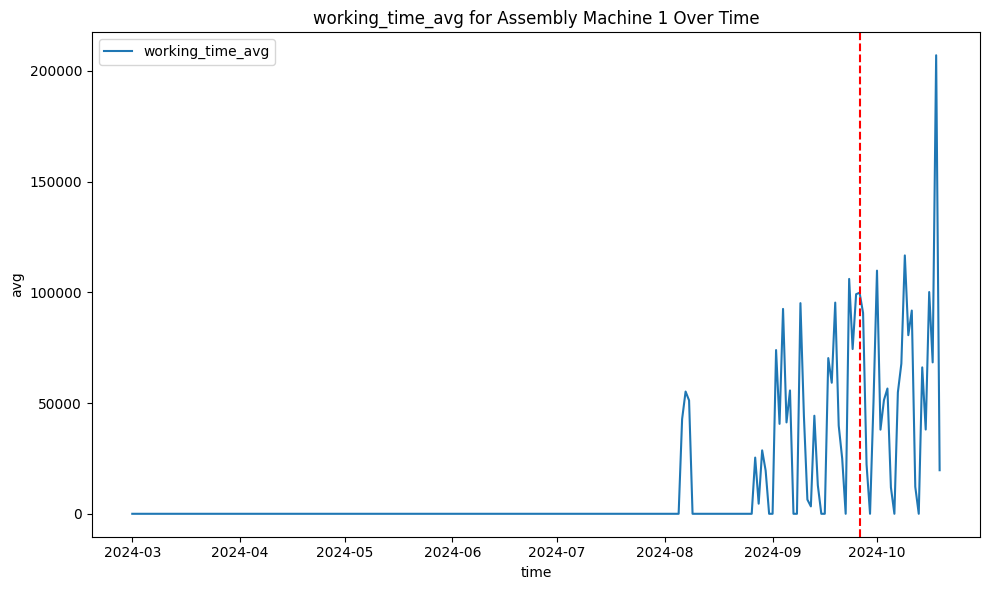

In [ ]:
from river import drift

# ADWIN drift detector
# THIS IS THE ONE WE WILL USE

def ADWIN_drift(features, machine_name, kpi_name, kpi_value, delta=0.002, clock=10):
    """
    Plots the values in the second column of 'features' DataFrame over the first column,
    and highlights potential drift points detected by ADWIN.

    Args:
        features (pd.DataFrame): The input data containing two columns to plot ['time'], [metric]
        machine_name (str): The name of the machine (for plot title).
        kpi_name (str): The name of the KPI (for plot title).
        delta (float): The sensitivity parameter for ADWIN (smaller values are more sensitive).
        clock (int): How often ADWIN should check for changes. 1 means every new data point, default is 32.
    """

    # Create ADWIN detector
    adwin = drift.ADWIN(delta=delta, clock=clock)

    # Initialize variable drift as False
    drift = False

    # Store drift points
    drift_points = []

    # Iterate through the values in the second column and detect drift
    for i, value in enumerate(features.iloc[:, 1]):
        adwin.update(value)
        if adwin.drift_detected:                       # if drift is detected, store index
            drift_points.append(i)
            print(f'Change detected at index {i}')
            drift = True
            if drift == True:
                # here we should call model retraining
                print("Retrain model")
                # after model has been retrained
                drift = False
                print("Model retrained")


    # THESE ARE FOR THE PLOT :

    # Create a figure and axes for the plot
    fig, ax = plt.subplots(figsize=(10, 6)) # This line creates the figure and axes

    # Plot the second column over the first column
    ax.plot(features.iloc[:, 0], features.iloc[:, 1], label=f"{kpi_name}_{kpi_value}") # Change axes[0] to ax
    ax.set_title(f"{kpi_name}_{kpi_value} for {machine_name} Over Time") # Change axes[0] to ax
    ax.set_xlabel(features.columns[0]) # Change axes[0] to ax
    ax.set_ylabel(features.columns[1]) # Change axes[0] to ax
    ax.legend() # Change axes[0] to ax

    # Highlight drift points on the time series plot
    for drift_point in drift_points:
        ax.axvline(x=features.iloc[drift_point, 0], color='red', linestyle='--', label='Drift Detected')

    plt.tight_layout()
    plt.show()




# Assuming 'features' is your DataFrame created earlier
ADWIN_drift(feature_extracted, machine, kpi, metric)

Change detected at index 207


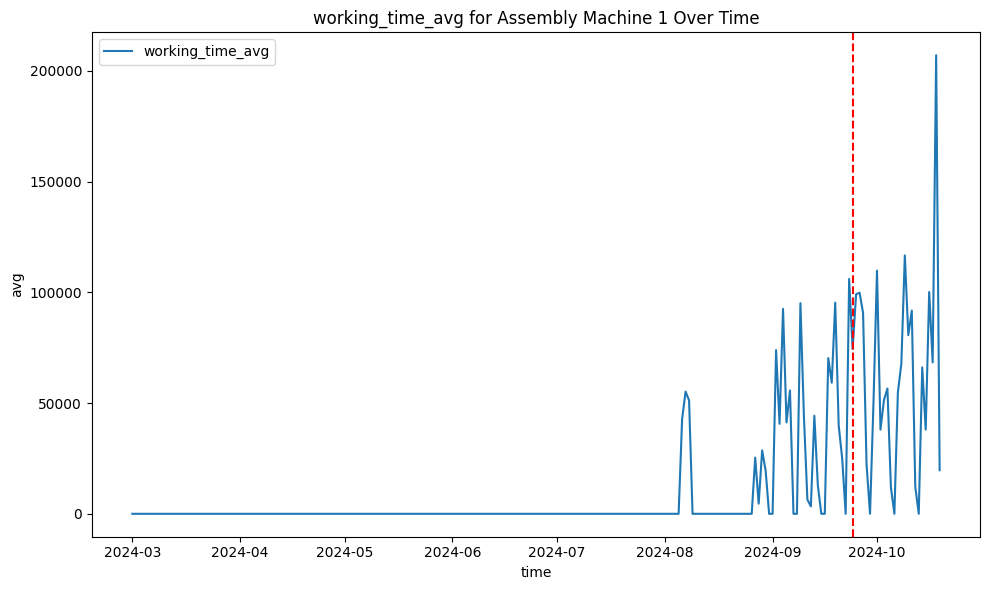

In [ ]:
# Kolmogorov_Smirnov_Test for drift detection

def KSWIN_drift(features, machine_name, kpi_name, kpi_value, alpha=0.00001):
    """
    Plots the values in the second column of 'features' DataFrame over the first column,
    its probability density function, and highlights potential drift points detected by ADWIN.

    Args:
        features (pd.DataFrame): The input data containing two columns to plot.
        machine_name (str): The name of the machine (for plot title).
        kpi_name (str): The name of the KPI (for plot title).
        alpha (float): Probability for the test statistic of the Kolmogorov-Smirnov-Test.
        The alpha parameter is very sensitive, therefore should be set below 0.01
    """

    # Create ADWIN detector
    kswin = drift.KSWIN(alpha=alpha)

    # Store drift points
    drift_points = []

    # Iterate through the values in the second column and detect drift
    for i, value in enumerate(features.iloc[:, 1]):
        kswin.update(value)
        if kswin.drift_detected:
            drift_points.append(i)
            print(f'Change detected at index {i}')

    # Create a figure and axes for the plot
    fig, ax = plt.subplots(figsize=(10, 6)) # This line creates the figure and axes

    # Plot the second column over the first column
    ax.plot(features.iloc[:, 0], features.iloc[:, 1], label=f"{kpi_name}_{kpi_value}")
    ax.set_title(f"{kpi_name}_{kpi_value} for {machine_name} Over Time")
    ax.set_xlabel(features.columns[0])
    ax.set_ylabel(features.columns[1])
    ax.legend()

    # Highlight drift points on the time series plot
    for drift_point in drift_points:
        ax.axvline(x=features.iloc[drift_point, 0], color='red', linestyle='--', label='Drift Detected')

    plt.tight_layout()
    plt.show()


# Assuming 'features' is your DataFrame created earlier
KSWIN_drift(feature_extracted, machine, kpi, metric)

Change detected at index 158
Change detected at index 188
Change detected at index 218


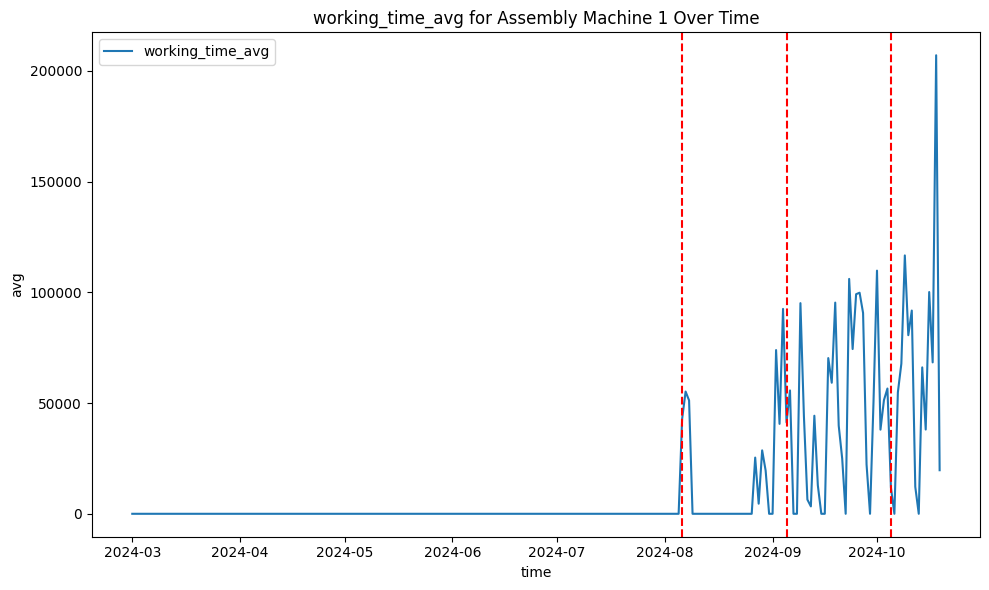

In [ ]:
# Page_Hinkley method for drift detection
def PG_drift(features, machine_name, kpi_name, kpi_value, delta=0.005):
    """
    Plots the values in the second column of 'features' DataFrame over the first column,
    its probability density function, and highlights potential drift points detected by ADWIN.

    Args:
        features (pd.DataFrame): The input data containing two columns to plot.
        machine_name (str): The name of the machine (for plot title).
        kpi_name (str): The name of the KPI (for plot title).
        alpha (float): Probability for the test statistic of the Kolmogorov-Smirnov-Test.
        The alpha parameter is very sensitive, therefore should be set below 0.01
    """

    # Create ADWIN detector
    pg = drift.PageHinkley(delta = delta)

    # Store drift points
    drift_points = []

    # Iterate through the values in the second column and detect drift
    for i, value in enumerate(features.iloc[:, 1]):
        pg.update(value)
        if pg.drift_detected:
            drift_points.append(i)
            print(f'Change detected at index {i}')

    # Create a figure and axes for the plot
    fig, ax = plt.subplots(figsize=(10, 6)) # This line creates the figure and axes

    # Plot the second column over the first column
    ax.plot(features.iloc[:, 0], features.iloc[:, 1], label=f"{kpi_name}_{kpi_value}")
    ax.set_title(f"{kpi_name}_{kpi_value} for {machine_name} Over Time")
    ax.set_xlabel(features.columns[0])
    ax.set_ylabel(features.columns[1])
    ax.legend()

    # Highlight drift points on the time series plot
    for drift_point in drift_points:
        ax.axvline(x=features.iloc[drift_point, 0], color='red', linestyle='--', label='Drift Detected')

    plt.tight_layout()

    plt.tight_layout()
    plt.show()


# Assuming 'features' is your DataFrame created earlier
PG_drift(feature_extracted, machine, kpi, metric)